# Setup

Given a random baseball team, we wish to predict whether that team will win the world series. We do not include teams which did not make the playoffs, though this is an interesting idea and probably much harder/noisier. We will use a number of different models to see which performs better. 

In [2]:
import warnings; warnings.filterwarnings("ignore") # hide Python warnings 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from dplython import (DplyFrame, X, diamonds, select, sift, sample_n,
    sample_frac, head, arrange, mutate, group_by, summarize, DelayFunction) 
from plotnine import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [3]:
teams = pd.read_csv('https://raw.githubusercontent.com/chadwickbureau/baseballdatabank/master/core/Teams.csv')
teams.columns

Index(['yearID', 'lgID', 'teamID', 'franchID', 'divID', 'Rank', 'G', 'Ghome',
       'W', 'L', 'DivWin', 'WCWin', 'LgWin', 'WSWin', 'R', 'AB', 'H', '2B',
       '3B', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF', 'RA', 'ER', 'ERA',
       'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP',
       'name', 'park', 'attendance', 'BPF', 'PPF', 'teamIDBR',
       'teamIDlahman45', 'teamIDretro'],
      dtype='object')

In [4]:

# Filtering out seasons before 1970
teams = teams[teams['yearID']>=1970]

# Filtering out teams that did not make it to the playoffs.
teams = teams[(teams['DivWin']=="Y") | (teams['WCWin']=="Y")]

# useless columns to drop
dropped_cols = ['Rank','G','Ghome','teamIDBR','teamIDlahman45','teamIDretro','DivWin','WCWin',
       'LgWin','name','park']

teams = teams.drop(dropped_cols, axis=1)
# Replace Y and N with 1 and 0
#teams.WSWin = teams.WSWin.replace(to_replace=['N','Y'], value=[0,1])
oldteams = teams.copy()

In [5]:


# Adding stats like OBP, OPS, etc
teams['PA'] = teams['AB'] + teams['BB'] + teams['HBP']
teams['OBP'] = (teams['H'] + teams['BB']+teams['HBP']) / teams['PA']
teams['TB'] = teams['H'] + teams['2B'] + 2*teams['3B'] + 3*teams['HR'] 
teams['SLG'] = teams['TB']/teams['AB']
teams['OPS'] = teams['SLG'] + teams['OBP']
teams['hit_rate'] = teams['H'] / teams['PA']
teams['sing_rate'] = (teams['H']-teams['2B']- teams['3B']-teams['HR'])/teams['PA']
teams['doub_rate'] = teams['2B']/teams['PA']
teams['trip_rate'] = teams['3B']/teams['PA']
teams['dong_rate'] = teams['HR']/teams['PA']
teams['walk_rate'] = teams['BB']/teams['PA']
teams['hbp_rate'] = teams['HBP']/teams['PA']

In [6]:
teams.columns

# Replace categorical variables with dummy 0/1 variables/vectors
#teams = pd.get_dummies(teams)

Index(['yearID', 'lgID', 'teamID', 'franchID', 'divID', 'W', 'L', 'WSWin', 'R',
       'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF', 'RA',
       'ER', 'ERA', 'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA',
       'E', 'DP', 'FP', 'attendance', 'BPF', 'PPF', 'PA', 'OBP', 'TB', 'SLG',
       'OPS', 'hit_rate', 'sing_rate', 'doub_rate', 'trip_rate', 'dong_rate',
       'walk_rate', 'hbp_rate'],
      dtype='object')

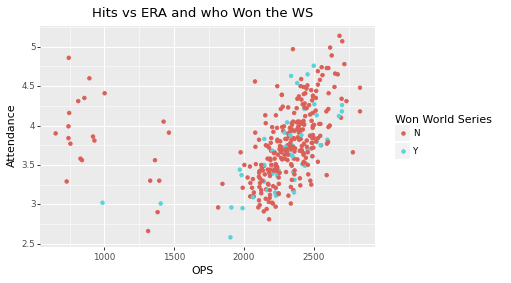

<ggplot: (8751996178487)>

In [7]:
(
    ggplot(teams)
    + aes(x="TB", y="ERA", color="WSWin", )
    + labs(
        x = "OPS",
        y = "Attendance",
        color="Won World Series",
        title="Hits vs ERA and who Won the WS",
    )
    + geom_point()
)

In [43]:
#corr = oldteams.corr()
#corr.style.background_gradient(cmap='coolwarm').set_precision(2)

In [41]:
corr = teams.corrwith((teams['WSWin'] == 'Y')*1.0)
pd.DataFrame(corr).style.background_gradient(cmap='coolwarm').set_precision(2)

/tmp/ipykernel_1240305/1973101650.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
/home/zach/.local/lib/python3.8/site-packages/pandas/io/formats/style.py:3559: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.


,0
yearID,-0.15
W,0.10
L,-0.02
R,0.05
AB,0.06
H,0.08
2B,0.02
3B,0.13
HR,-0.06
BB,0.02


In [42]:
teams.isna().sum().sum()

0

In [11]:
teams_noID = teams.drop(columns=["lgID", "franchID", "divID"], axis=1)
teams = pd.get_dummies(teams, columns=["lgID", "franchID", "divID"])

In [12]:
teams.head()

,yearID,teamID,W,L,WSWin,R,AB,H,2B,3B,...,franchID_SEA,franchID_SFG,franchID_STL,franchID_TBD,franchID_TEX,franchID_TOR,franchID_WSN,divID_C,divID_E,divID_W
1542,1970,BAL,108,54,Y,792,5545,1424,213,25,...,0,0,0,0,0,0,0,0,1,0
1547,1970,CIN,102,60,N,775,5540,1498,253,45,...,0,0,0,0,0,0,0,0,0,1
1553,1970,MIN,98,64,N,744,5483,1438,230,41,...,0,0,0,0,0,0,0,0,0,1
1560,1970,PIT,89,73,N,729,5637,1522,235,70,...,0,0,0,0,0,0,0,0,1,0
1566,1971,BAL,101,57,N,742,5303,1382,207,25,...,0,0,0,0,0,0,0,0,1,0


In [14]:
# Making a nicer looking confusion matrix

def pretty_confusion(y_test, y_pred):
    ax= plt.subplot()
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['N', 'Y']); ax.yaxis.set_ticklabels(['N', 'Y']);

In [15]:
y = teams.WSWin
X = teams.drop(['yearID', 'teamID', 'WSWin'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=65537)

# Training model without team/lg/div names
#y_n = teams_noID.WSWin
#X_n = teams_noID.drop(['yearID', 'teamID', 'WSWin'], axis=1)

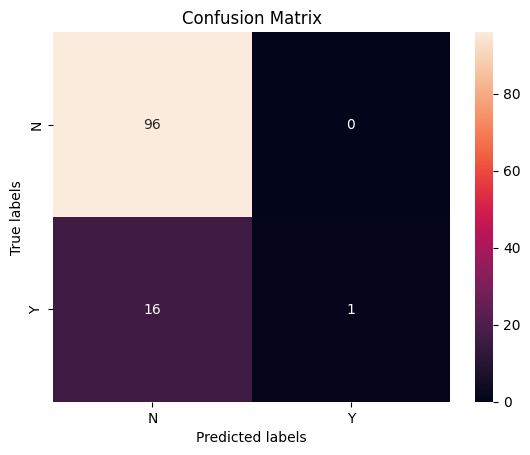

In [16]:
glm = LogisticRegression(solver='liblinear', penalty='l1')
glm.fit(X_train, y_train)
y_pred = glm.predict(X_test)
pretty_confusion(y_test, y_pred)

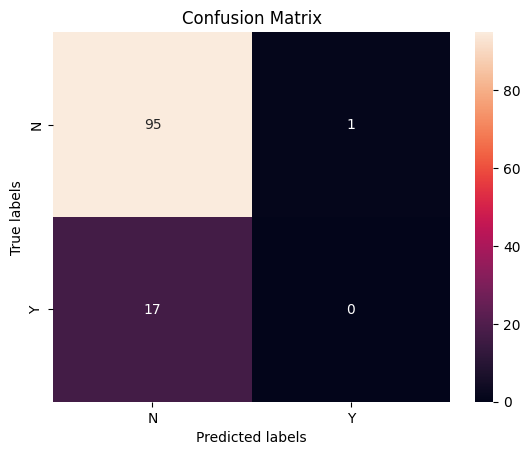

In [20]:
clf = RandomForestClassifier(max_depth=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
pretty_confusion(y_test, y_pred)

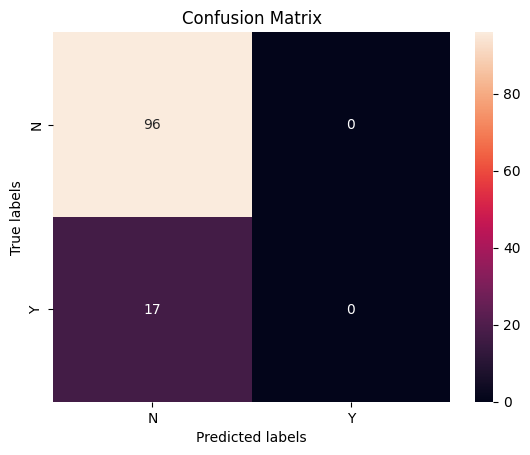

In [27]:
svc = SVC(C=1, kernel='rbf')
svc.fit(X_train, y_train)
y_pred = clf.predict(X_test)
pretty_confusion(y_test, y_pred)

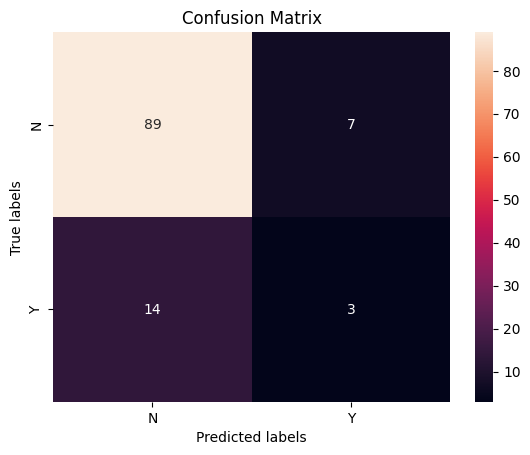

In [29]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
pretty_confusion(y_test, y_pred)

In [81]:
#skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
#clf = RandomForestClassifier(max_depth=3)
#clf.fit(X,y)
#lreg = LogisticRegression(solver='liblinear', penalty='l1')

In [82]:
#clf_n = RandomForestClassifier(max_depth=3)
#clf_n.fit(X_n,y_n)
#lreg_n = LogisticRegression(solver='liblinear', penalty='l1')

In [89]:

#clf_scores = cross_val_score(clf, X, y, cv=skf, scoring='accuracy')
#print(clf_scores)
#clf_scores = cross_val_score(clf, X, y, cv=skf, scoring='accuracy')
#print(clf_scores)
#clf_scores = cross_val_score(lreg, X, y, cv=skf, scoring='accuracy')
#print(clf_scores)

[0.7826087  0.84057971 0.85294118 0.85294118 0.85294118]
[0.37681159 0.8115942  0.75       0.83823529 0.85294118]


In [90]:
#clf_scores = cross_val_score(clf, X, y, cv=skf, scoring='accuracy')
#print(clf_scores)
#clf_scores = cross_val_score(clf_n, X_n, y_n, cv=skf, scoring='accuracy')
#print(clf_scores)
#clf_scores = cross_val_score(lreg_n, X_n, y_n, cv=skf, scoring='accuracy')
#print(clf_scores)

[0.7826087  0.79710145 0.80882353 0.85294118 0.85294118]
[0.4057971  0.82608696 0.79411765 0.85294118 0.85294118]
